# 02_1_DESIGN_Combinatorial_library

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/02_1_DESIGN_Combinatorial_library.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [6]:
%%capture
!pip install pydna
!pip install Bio
!pip install ConStrain

Sometimes the dependencies doesen't work at first but by running the cell above it is possible to run the notebook. 

# 03-Combinatorial_library_with_DesignAssembly.ipynb

In [7]:
import pandas as pd
from pydna.dseqrecord import Dseqrecord
from IPython import display

# to show assemblies
from pydna.assembly import Assembly

# Biopython I/O + biopython objects
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import numpy as np

In [8]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 1. Intro

Up until now, the previous notebooks have enabled us to retrieve DNA sequences for the construction of combinatorial libraries. There are plenty of good reasons to make combinatorial libraries which I will not go into detail about here but for more information read **"Combinatorial pathway optimization for streamlined metabolic engineering"** by Jeschek et al 2017. The focus of this notebook is to show how combinatorial libraries can be made with a literate programming approach.  

**The general method to accomblish this is as follows:**

1. Retrieve sequences of interest, along with names
2. Make amplicons from sequences consisting of primers and their annealing temperatures
3. Generate combinatorial lists of all possible combinations
4. If a pad is wanted, add the pad at a chosen location in each list
5. Assemble contigs by making overlapping primers between each amplicon
6. Save all primers
7. Primers containing the same sequences are updated to have the same names ( happens quite frequently with homologs)
8. Unique primers are saved
9. Unique amplicons are saved


Last part of this notebook includes how robot instructions can be made from the DesignAssembly object or from predefined plates. 

**Contents of this notebook:**
    
1. Fetching data from FASTA files
2. Generating a combinatorial library for the G8H bottleneck
3. Generating Robot excecutable intructions with focus on FLOWBOT instruction

## 1.1 Data aquisition and processing
Previously I found homologs and promoters to have the neccessary parts to build a combinatorial library. These parts can be fetched from databases such as benchling or Teselagen but for ease of use it shown with fasta files here. These files are read and made into Biopython objects that that can be used for the genetic constructs. 

To build a combinatorial library from the generated promoters and homologs some of them need to be reversed. Namely, the upstream part from the pad which we can easily do with a simple Python trick (see below). 

In [12]:
CYP_sites = []
CPR_sites = []
pCPR_sites = []
pCYP_sites = []

# GEtting the objects from the fasta files
#G8H_CPR and Promoter seqs1
for seq_record in SeqIO.parse('ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/CPR_tCYC1_-_2022-06-06.gb', format= 'gb'):
    CPR_sites.append(seq_record)
    
for seq_record in SeqIO.parse('ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/CPR_promoters_-_2022-06-06.gb', format= 'gb'):
    pCPR_sites.append(seq_record)
    
# REVERSE COMPLEMENT THE DNA HERE TO MAKE THE CONSTRUCTS IN THE CORRECT ORIENTATION
# G8H_CYP and Promoter seqs2
for seq_record in SeqIO.parse('ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/G8H_tADH1_-_2022-06-06.gb', format= 'gb'):    
    CYP_sites.append(seq_record[::-1])
    
for seq_record in SeqIO.parse('ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/G8H_promoters_-_2022-06-06.gb', format= 'gb'):
    pCYP_sites.append(seq_record[::-1])

Lets check that the information is read in, correctly and that the right amount of constructs are there and no mistakes have been made. 

In [13]:
print(CPR_sites[0])

ID: pL_01_C7\(pRS415-USER).0
Name: AhuCPR_tCYC1
Number of features: 2
/molecule_type=ds-DNA
/topology=linear
/data_file_division=   
/date=13-DEC-2020
/accessions=['pL_01_C7\\(pRS415-USER)']
/sequence_version=0
/keywords=['"Antibiotic resistance" "Backbones" "Cloning sites" "Comment" "DNA fragments" "Design entry" "Genes:AmpR" "LabCollector ID" "Markers" "Origin of replication:CEN6 ARS4" "Parent plasmids" "Promoters:Bla promoter" "Protein" "RBS" "Responsible person/group" "Spacers" "Status" "Tags" "Terminators" "Usage" "gRNAs"']
Seq('ATGGACTCCTCATCGGAGAAGCTTTCCCCGTTCGACTTAATGACGGCAATCCTA...GAA')


In [14]:
print(len(pCPR_sites))
print(len(CPR_sites))
print(len(CYP_sites))
print(len(pCYP_sites))

print('Total combinations', len(CPR_sites)*len(pCPR_sites)*len(pCYP_sites)*len(CYP_sites))

4
10
8
4
Total combinations 1280


Now lets fetch the up/down sites of XI-2 and the Trp marker. 

In [15]:
UP_DW_marker = []
for seq_record in SeqIO.parse('ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/UP_DW_Marker.fasta', format= 'fasta'):
    UP_DW_marker.append(seq_record)
UP_DW_marker

[SeqRecord(seq=Seq('GAGGATTTTCGATGGAGCAGGATGAGGAGAAATAGTACCACATGTATATATCCA...CAA'), id='UP_XI-2', name='UP_XI-2', description='UP_XI-2 Upstream of XI-2 site', dbxrefs=[]),
 SeqRecord(seq=Seq('CACACGACTAGCGCTTTCAGATATTAAAAAGTTTAGATGTAGGTTTTAGCGGTA...CAC'), id='DW_XI-2', name='DW_XI-2', description='DW_XI-2 Downstream of XI-2 site', dbxrefs=[]),
 SeqRecord(seq=Seq('AGACGGTCACAGCTTGTCTGTAAGCGGATGCCGGGAGCAGACAAGCCCGTCAGG...ACG'), id='seq_3HMRtcpy', name='seq_3HMRtcpy', description='seq_3HMRtcpy <unknown description>', dbxrefs=[])]

In [16]:
UP_sites = UP_DW_marker[0]
DW_sites = UP_DW_marker[1]
marker_sites = UP_DW_marker[2]

Now the terminators ADH1 and CYC1

Now, the sequences needs to be made into Dseqrecord elements to make it into a DesignAssembly class. The names for these objects also need to be retrieved. 

In [17]:
#Getting the objects names
UP_sites_names = [UP_sites.name]
G8H_templates_names = [names.name for names in CYP_sites]
pG8H_templates_names = [names.name for names in pCYP_sites]
pG8H_CPR_templates_names = [names.name for names in pCPR_sites]
G8H_CPR_templates_names = [names.name for names in CPR_sites]
marker_templates_names = [marker_sites.name]
DW_sites_names = [DW_sites.name]

# Getting their sequences
UP_sites_seqrecord = [Dseqrecord(UP_sites.seq) ]
G8H_templates_seqrecord = [Dseqrecord(seq.seq) for seq in CYP_sites]
pG8H_templates_seqrecord = [Dseqrecord(seq.seq) for seq in pCYP_sites]
pCPR_templates_seqrecord = [Dseqrecord(seq.seq) for seq in pCPR_sites]
G8H_CPR_templates_seqrecord = [Dseqrecord(seq.seq) for seq in CPR_sites]
marker_templates_seqrecord = [Dseqrecord(marker_sites.seq) ]
DW_sites_seqrecord = [Dseqrecord(DW_sites.seq)]

In [18]:
G8H_templates_seqrecord

[Dseqrecord(-1803),
 Dseqrecord(-1695),
 Dseqrecord(-1860),
 Dseqrecord(-1827),
 Dseqrecord(-1803),
 Dseqrecord(-1809),
 Dseqrecord(-1803),
 Dseqrecord(-1803)]

In [202]:
import numpy as np
from scipy.integrate import odeint
import dnaplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [309]:
pG8H = {'name':'P_G8H', 'start':-1, 'end':-10, 'type':'Promoter', 'opts': {'color':[0.00,0.00,0.00]}}
G8H = {'name':'G8H-homologs', 'start':-21, 'end':-40, 'type':'CDS', 'opts':{'label': 'G8H-homologs', 'fontsize': 8,  'label_y_offset': 0, 'label_x_offset': 0, 'label_style':'italic', 'color':[0.65,0.81,0.89]}} # 0.65,0.81,0.89
t_adh1 = {'name':'T_ADH1', 'start':-41, 'end':-55, 'type':'Terminator'}
up = {'name':'Up', 'start':-41, 'end':-55, 'type':'Scar', 'opts':{'label': 'up',  'label_y_offset': 0, 'label_x_offset': 0,  'color':[0.60,0.60,0.60]}}


pCPR = {'name':'P_CPR', 'start':56, 'end':65, 'type':'Promoter', 'opts': {'color':[0.00,0.00,0.00]}}
CPR = {'name':'CPR-homologs', 'start':76, 'end':95, 'type':'CDS', 'opts':{'label': 'CPR-homologs', 'fontsize': 8,  'label_y_offset': 0, 'label_x_offset': -2, 'label_style':'italic', 'color':[0.79,0.70,0.84]}} # 0.79,0.70,0.84
t_cyc1 = {'name':'T_CYC1', 'start':96, 'end':110, 'type':'Terminator'}
dw = {'name':'dw', 'start':-41, 'end':-55, 'type':'Scar', 'opts':{'label': 'dw',  'label_y_offset': 0, 'label_x_offset': 0,  'color':[0.60,0.60,0.60]}}

Now, for making the G8G de-bottlenecking construct. This can be achieved by following the scheme below and adding the genetic parts into lists that will be put into: 1) list of sequences 2) a list of names (final product - list of list)

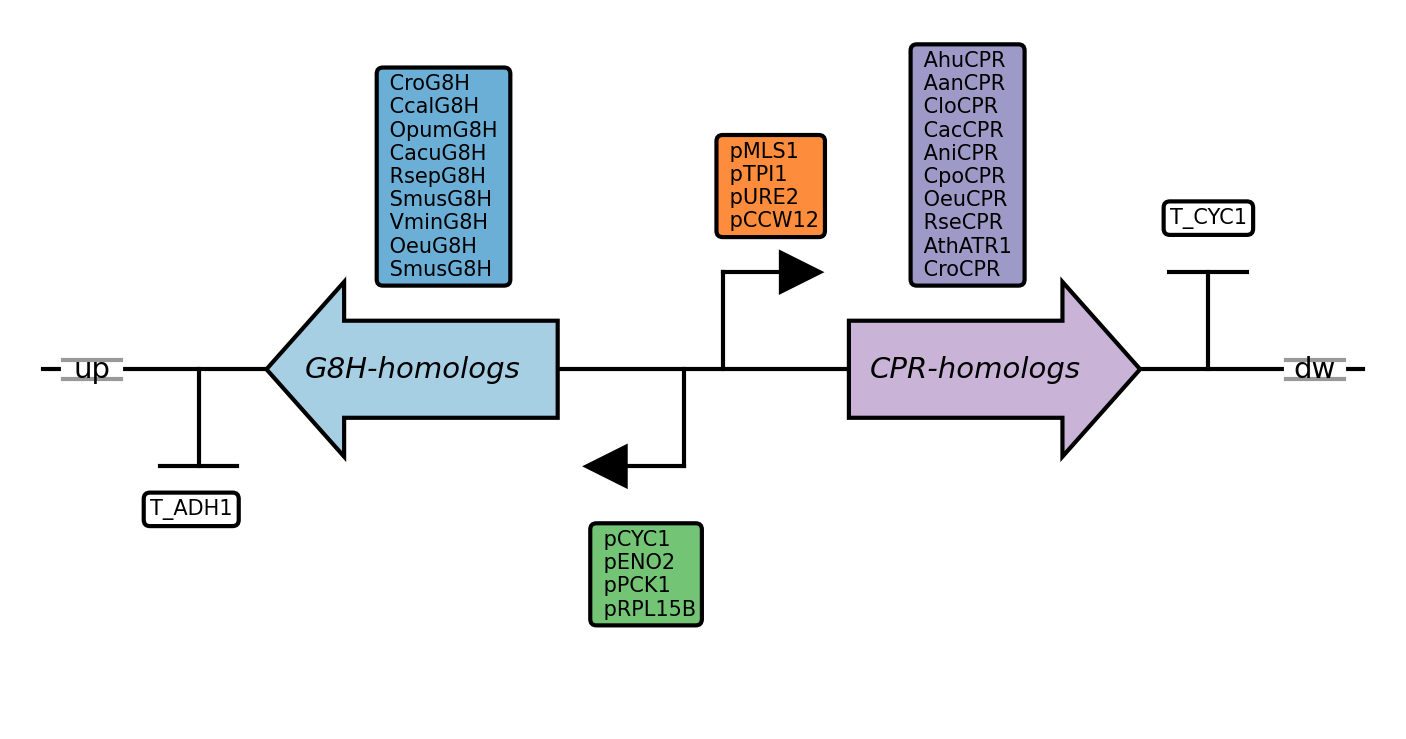

In [310]:
plt.figure(figsize=(10, 3),dpi=300)
gs = gridspec.GridSpec(1, 1)

# Plot G8H construct
ax = plt.subplot(gs[0])
dnaplotlib.plot_sbol_designs([ax], [[up, t_adh1, G8H,pG8H, pCPR,  CPR, t_cyc1, dw]])

#### Plot text
# terminators
plt.text(11,-15, 'T_ADH1', ha='left', rotation=0, wrap=True,  size = 5,
         # adds box
        bbox=dict(boxstyle="round",facecolor='white'))
plt.text(124,15, 'T_CYC1', ha='right', rotation=0, wrap=True,  size = 5,
         # adds box
        bbox=dict(boxstyle="round",facecolor='white'))

# promoters
plt.text(57,-25, ' pCYC1 \n pENO2 \n pPCK1 \n pRPL15B', ha='left', rotation=0, wrap=True,  size = 5,
        bbox=dict(boxstyle="round",facecolor='#74c476'))
plt.text(70,15, ' pMLS1 \n pTPI1 \n pURE2 \n pCCW12', ha='left', rotation=0, wrap=True,  size = 5,
         # adds box
        bbox=dict(boxstyle="round",facecolor='#fd8d3c'))


# homologs
plt.text(35,10, ' CroG8H \n CcalG8H \n OpumG8H \n CacuG8H \n RsepG8H \n SmusG8H \n VminG8H \n OeuG8H \n SmusG8H', ha='left', rotation=0, wrap=True,  size = 5, 
        # adds box
        bbox=dict(boxstyle="round",facecolor='#6baed6'))

plt.text(90,10, ' AhuCPR \n AanCPR \n CloCPR \n CacCPR \n AniCPR \n CpoCPR \n OeuCPR \n RseCPR \n AthATR1 \n CroCPR', ha='left', rotation=0, wrap=True,  size = 5, 
        # adds box
        bbox=dict(boxstyle="round",facecolor='#9e9ac8'))



name = 'Genetic construct w dnaplotlib'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/'+name+'.svg',format = 'SVG',  dpi = 300)
plt.savefig('ConStrain_on_google_colab/pictures/'+name+'.png',format = 'png',  dpi = 300)


In [311]:
list_of_seqs = [UP_sites_seqrecord, G8H_templates_seqrecord, pG8H_templates_seqrecord, pCPR_templates_seqrecord, G8H_CPR_templates_seqrecord, marker_templates_seqrecord, DW_sites_seqrecord]

list_of_names = [UP_sites_names,G8H_templates_names, pG8H_templates_names, pG8H_CPR_templates_names, G8H_CPR_templates_names, marker_templates_names, DW_sites_names]

# Check that the lists are the same lenght
if len(list_of_seqs) != len(list_of_names): 
    print('!!!!!!!!!!!!!!!!!The lengths are not the same, check the sequences!!!!!!!!!!!!!!!!!!')
else: 
    print('The lengths are the same')

The lengths are the same


Now it's a good idea at this point to make sure that all the objects have been made into Dseqrecords and that they have the right size and configuration.  

In [160]:
list_of_seqs

[[Dseqrecord(-569)],
 [Dseqrecord(-1803),
  Dseqrecord(-1695),
  Dseqrecord(-1860),
  Dseqrecord(-1827),
  Dseqrecord(-1803),
  Dseqrecord(-1809),
  Dseqrecord(-1803),
  Dseqrecord(-1803)],
 [Dseqrecord(-991), Dseqrecord(-1004), Dseqrecord(-1004), Dseqrecord(-984)],
 [Dseqrecord(-1004), Dseqrecord(-1004), Dseqrecord(-1003), Dseqrecord(-984)],
 [Dseqrecord(-2328),
  Dseqrecord(-2298),
  Dseqrecord(-2328),
  Dseqrecord(-2310),
  Dseqrecord(-2268),
  Dseqrecord(-2223),
  Dseqrecord(-2310),
  Dseqrecord(-2328),
  Dseqrecord(-2262),
  Dseqrecord(-2328)],
 [Dseqrecord(-1415)],
 [Dseqrecord(-563)]]

In [161]:
list_of_names

[['UP_XI-2'],
 ['CcalG8H_tADH1',
  'CroG8H_tADH1',
  'OpumG8H_tADH1',
  'CacuG8H_tADH1',
  'RsepG8H_tADH1',
  'SmusG8H_tADH1',
  'VminG8H_tADH1',
  'OeuG8H_tADH1'],
 ['pCYC1', 'pENO2', 'pPCK1', 'pRPL15B'],
 ['pMLS1', 'pTPI1', 'pURE2', 'pCCW12'],
 ['AhuCPR_tCYC1',
  'AanCPR_tCYC1',
  'CloCPR_tCYC1',
  'CacCPR_tCYC1',
  'AniCPR_tCYC1',
  'CpoCPR_tCYC1',
  'OeuCPR_tCYC1',
  'RseCPR_tCYC1',
  'AthATR1_tCYC1',
  'CroCPR_tCYC1'],
 ['seq_3HMRtcpy'],
 ['DW_XI-2']]

### Things to look out for when running DesignAssembly. 

1. if the melting temperature is set too low it will make a warning saying that PCR_prod is not unique. It helps to raise the melting temperature if that happens so it can make longer and unique primers 

# 2. Initiating the DesignAssembly class

Before we initiate the designAssembly object we can define and add a piece of DNA that can be used for easier genotyping and contain a crRNA so we can delete the genetic module if we need to. Below, a pad consisting of a ATF1 CRISPR Guide RNA flanked by arbitrary sequences is inititalized as a pad  

In [15]:
# ATF1_CRISPR_Guide_RNA = 'CTATGCTGTCGGATGAGTCC'
pad = Dseqrecord('GTATAGGACGCTATGCTGTCGGATGAGTCCCGTAGAATGA')
pad

Dseqrecord(-40)

We simply initiate the class by calling it with the list of sequences, their names, the pad, and the position of the pad. 
This normally takes about 20 sec. 

In [16]:
from constrain.design.combinatorial_design import DesignAssembly


In [17]:
%%time
G8H_assembly = DesignAssembly(list_of_seqs, list_of_names, pad , 4 )

CPU times: user 9.45 s, sys: 106 ms, total: 9.56 s
Wall time: 14.2 s


The DesignAssembly class have class methods attached to it. These include displaying primers, the PCRs that needs to made and a graphical representation of the construts. 

The methods are as follows: 

- ShowContigs
- ShowVariantsLibDF
- PCR_list_to_dataframe
- print_PCR_list
- Primer_list_to_dataframe
- print_primer_list

Here it is shown how a dataframe with all the variants are generated:

In [18]:
combinatorial_lib_variants_df = G8H_assembly.ShowVariantsLibDF()
combinatorial_lib_variants_df

,0,1,2,3,4,5,6,Systematic_name,Variant
0,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,AhuCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 1, 1)",0
1,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,AanCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 2, 1, 1)",1
2,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,CloCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 3, 1, 1)",2
3,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,CacCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 4, 1, 1)",3
4,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,AniCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 5, 1, 1)",4
...,...,...,...,...,...,...,...,...,...
1115,UP_XI-2,OeuG8H_tADH1,pRPL15B,pCCW12,CpoCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 7, 4, 4, 6, 1, 1)",1115
1116,UP_XI-2,OeuG8H_tADH1,pRPL15B,pCCW12,OeuCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 7, 4, 4, 7, 1, 1)",1116
1117,UP_XI-2,OeuG8H_tADH1,pRPL15B,pCCW12,RseCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 7, 4, 4, 8, 1, 1)",1117
1118,UP_XI-2,OeuG8H_tADH1,pRPL15B,pCCW12,AthATR1_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 7, 4, 4, 9, 1, 1)",1118


We can change the coloumn names to get a better overview. 


In [19]:
combinatorial_lib_variants_df = combinatorial_lib_variants_df.rename(columns={0: 'UP_site',1: '<- G8H-CYP', 2: '<-Promoters1', 3:'Promoters2->', 4:'G8H-CPR->', 5:'Trp_marker->', 6:'Down_site'})
combinatorial_lib_variants_df

,UP_site,<- G8H-CYP,<-Promoters1,Promoters2->,G8H-CPR->,Trp_marker->,Down_site,Systematic_name,Variant
0,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,AhuCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 1, 1)",0
1,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,AanCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 2, 1, 1)",1
2,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,CloCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 3, 1, 1)",2
3,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,CacCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 4, 1, 1)",3
4,UP_XI-2,CcalG8H_tADH1,pCYC1,pMLS1,AniCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 5, 1, 1)",4
...,...,...,...,...,...,...,...,...,...
1115,UP_XI-2,OeuG8H_tADH1,pRPL15B,pCCW12,CpoCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 7, 4, 4, 6, 1, 1)",1115
1116,UP_XI-2,OeuG8H_tADH1,pRPL15B,pCCW12,OeuCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 7, 4, 4, 7, 1, 1)",1116
1117,UP_XI-2,OeuG8H_tADH1,pRPL15B,pCCW12,RseCPR_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 7, 4, 4, 8, 1, 1)",1117
1118,UP_XI-2,OeuG8H_tADH1,pRPL15B,pCCW12,AthATR1_tCYC1,seq_3HMRtcpy,DW_XI-2,"(1, 7, 4, 4, 9, 1, 1)",1118


Lets see how the first assembly overlaps. We can do that with the following code: 

In [21]:
# the first variant is chosen here
subset_of_the_assemblies = G8H_assembly.list_of_assemblies[0]
assemble = Assembly(subset_of_the_assemblies, limit = 30)
print(assemble.assemble_linear()[0].figure())

UP_XI-2|30
        \/
        /\
        30|CcalG8H_tADH1|30
                         \/
                         /\
                         30|pCYC1|30
                                  \/
                                  /\
                                  30|pMLS1|30
                                           \/
                                           /\
                                           30|AhuCPR_tCYC1|30
                                                           \/
                                                           /\
                                                           30|seq_3HMRtcpy|30
                                                                           \/
                                                                           /\
                                                                           30|DW_XI-2


How long is the contig?

In [22]:
assemble.assemble_linear()

[Contig(-8713)]

We can retrieve the primers needed for the assembly in the following way:

In [23]:
G8H_primer_df = G8H_assembly.primer_list_to_dataframe()
G8H_primer_df

,ID,Anneals to,Sequence,Annealing temperature,Length,Price(DKK)
0,F001,UP_XI-2,"(G, A, G, G, A, T, T, T, T, C, G, A, T, G, G, ...",57.29,18,32.4
1,F002,CcalG8H_tADH1,"(C, A, T, G, A, A, C, T, T, C, C, A, C, A, A, ...",55.96,37,66.6
2,F003,pCYC1,"(T, C, G, T, A, C, T, C, C, A, G, C, G, A, G, ...",56.37,42,75.6
3,F004,pMLS1,"(A, A, A, C, T, T, T, T, A, C, G, A, C, A, A, ...",56.11,35,63.0
4,F005,AhuCPR_tCYC1,"(G, G, A, C, G, C, T, A, T, G, C, T, G, T, C, ...",57.66,51,91.8
...,...,...,...,...,...,...
185,R186,UP_XI-2,"(A, C, A, A, T, T, C, T, T, C, A, G, G, T, A, ...",56.60,32,57.6
186,R187,OeuG8H_tADH1,"(G, T, G, A, T, T, T, A, A, T, T, A, T, T, T, ...",56.54,30,54.0
187,R188,OeuG8H_tADH1,"(T, G, T, A, T, G, T, T, A, T, T, A, T, T, T, ...",56.54,30,54.0
188,R189,OeuG8H_tADH1,"(T, A, T, T, T, T, A, T, T, G, T, T, G, T, T, ...",56.54,30,54.0


In [24]:
Total_bases = G8H_primer_df['Length'].sum()
Total_bases

7883

In [25]:
Total_price = G8H_primer_df['Price(DKK)'].sum()
print(f"The total price of the primers for the library is: {Total_price:.0f}")

The total price of the primers for the library is: 14189


In [26]:
larger_than_60 = G8H_primer_df[G8H_primer_df.Length > 60]
len(larger_than_60)

12

If we want to take a closer look at the PCRs needed to complete the library do the following: 

In [27]:
G8H_pcr_df = G8H_assembly.PCR_list_to_dataframe()
G8H_pcr_df

,PCR#,Template,forward_primer,reverse_primer,F_tm,R_tm
0,PCR1,UP_XI-2,F001,R104,57.29,56.60
1,PCR2,CcalG8H_tADH1,F002,R187,55.96,56.54
2,PCR3,pCYC1,F100,R106,56.37,56.64
3,PCR4,pMLS1,F004,R122,56.11,56.18
4,PCR5,AhuCPR_tCYC1,F049,R124,57.66,57.04
...,...,...,...,...,...,...
74,PCR75,UP_XI-2,F001,R186,57.29,56.60
75,PCR76,OeuG8H_tADH1,F099,R187,56.04,56.54
76,PCR77,OeuG8H_tADH1,F099,R188,56.04,56.54
77,PCR78,OeuG8H_tADH1,F099,R189,56.04,56.54


With this information it is possible to: 
1. Order the primers
2. Go into the lab and make the PCRs.

Now, making that many PCRs can be a tough/tedious task to perform so lets make robot instructions that can help us increase the speed at which we make the library and limit mistakes. 

# 3. Tesselagens library

In [28]:
lea_primers = pd.read_excel("ConStrain_on_google_colab/Data/Teselagen/G8H_CPR_library.xls", sheet_name = "all primers").reset_index(drop=True)
lea_primers

,Id,Name,Target Parts,Size,Cost,Tm,Tm (3' only),Sequence (3' only),Sequence,Location
0,3460,PR_UP_tADH1_05,XI-2_UP,22,2.2,58.178,58.178,GAGGATTTTCGATGGAGC,GAGGATTTTCGATGGAGC,o2_I06
1,3461,PR_UP_tADH1_06,XI-2_UP,64,6.4,69.335,57.264,TTGTGGAAGTTCATGGC,TAGGTCAGGTTGCTTTCTCAGGTATAGCATGAGGTCGCTCTTGTGG...,o2_I07
2,3407,PR_G8H_01,"VminG8H_tADH1,SmusG8H_tADH1,RsepG8H_tADH1,Cacu...",19,1.9,57.335,57.335,GAGCGACCTCATGCTATAC,GAGCGACCTCATGCTATAC,op4_A10
3,3408,PR_G8H_02,"VminG8H_tADH1,TIS_AAAACA",62,6.2,63.653,57.979,ATGGATTACTTGACGATCGC,AGACACACAAACACAAATACACACACTAAATTAATAAAAACAATGG...,op4_A01
4,3409,PR_G8H_03,"VminG8H_tADH1,TIS_AAAACA",61,6.1,64.693,57.979,ATGGATTACTTGACGATCGC,ACACCAAGCAACTAATACTATAACATACAATAATAAAAACAATGGA...,op4_B01
...,...,...,...,...,...,...,...,...,...,...
91,3370,PR_CPR_02,"CroCPR_tCYC1,RseCPR_tCYC1,OeuCPR_tCYC1,CpoCPR_...",20,2.0,56.289,56.289,TTCTCAAGCAAGGTTTTCAG,TTCTCAAGCAAGGTTTTCAG,op4_B10
92,3468,PR_TRP1-DW_01,TRP1-marker,61,6.1,72.322,66.788,AGACGGTCACAGCTTGTCTGTAAGC,CGCATGTAACATTATACTGAAAACCTTGCTTGAGAAAGACGGTCAC...,op4_C10
93,3469,PR_TRP1-DW_02,TRP1-marker,18,1.8,65.423,65.423,CGTAGTGGGCCATCGCCC,CGTAGTGGGCCATCGCCC,op4_D10
94,3470,PR_TRP1-DW_05,XI-2_DW,63,6.3,66.938,58.341,CACACGACTAGCGCT,GCGAAAAACCGTCTATCAGGGCGATGGCCCACTACGCACACGACTA...,o2_I08


In [29]:
Total_bases_teselagen = lea_primers['Size'].sum()
Total_bases_teselagen

5328

In [30]:
Total_price = Total_bases_teselagen*1.8
print(f"The total price of the primers for the library is: {Total_price:.0f}")

The total price of the primers for the library is: 9590


In [31]:
larger_than_60 = lea_primers[lea_primers.Size > 60]
len(larger_than_60)

35

In [32]:
lea_parts = pd.read_excel("ConStrain_on_google_colab/Data/Teselagen/G8H_CPR_library.xls", sheet_name = "all parts").reset_index(drop=True)
lea_parts

,Overlaps_to,order,Part,Promoter,Id,Name,Note,Forward Oligo Id,Forward Oligo Name,Reverse Oligo Id,...,Q5_ta,Length,Sequence,Location,Template_location,Template_name,Box_barcode,volume,concentration,Column1
0,pCYC1,1,NaN,NaN,2339,PCR_G8H_01,PCR,3407,PR_G8H_01,3408,...,63,1845,GAGCGACCTCATGCTATACCTGAGAAAGCAACCTGACCTACAGGAA...,l5_A03,NaN,pMIA_087_Vmin_G8O_in_p0057_(TRP),81BOX762,100.0,40.0,NaN
1,pENO2,2,NaN,NaN,2340,PCR_G8H_02,PCR,3407,PR_G8H_01,3409,...,63,1844,GAGCGACCTCATGCTATACCTGAGAAAGCAACCTGACCTACAGGAA...,l5_A04,NaN,pMIA_087_Vmin_G8O_in_p0057_(TRP),81BOX762,100.0,45.0,NaN
2,pPCK1,3,NaN,NaN,2341,PCR_G8H_03,PCR,3407,PR_G8H_01,3410,...,63,1841,GAGCGACCTCATGCTATACCTGAGAAAGCAACCTGACCTACAGGAA...,l5_A05,NaN,pMIA_087_Vmin_G8O_in_p0057_(TRP),81BOX762,100.0,40.0,NaN
3,pRPL15B,4,NaN,NaN,2342,PCR_G8H_04,PCR,3407,PR_G8H_01,3411,...,63,1839,GAGCGACCTCATGCTATACCTGAGAAAGCAACCTGACCTACAGGAA...,l5_A06,NaN,pMIA_087_Vmin_G8O_in_p0057_(TRP),81BOX762,100.0,45.0,NaN
4,pCYC1,5,NaN,NaN,2343,PCR_G8H_05,PCR,3407,PR_G8H_01,3412,...,63,1851,GAGCGACCTCATGCTATACCTGAGAAAGCAACCTGACCTACAGGAA...,l5_A07,NaN,pMIA_090_Smus_G8O_in_p0057_(TRP),81BOX762,100.0,40.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,pMLS1,83,NaN,NaN,2323,PCR_CPR_25,PCR,3393,PR_CPR_25,3370,...,60,2264,CAAAGTAGTAAAAGCACATAAAAGAATTAAGAAATAAAACAATGGA...,l5_I05,NaN,PL_13_F3_(pRS415U-P2_TEF1-CpoCPR_opt2),81BOX762,100.0,35.0,NaN
83,pCCW12,84,NaN,NaN,2333,PCR_CPR_35,PCR,3402,PR_CPR_34,3370,...,60,2259,CTGTCATTCGCTTAAACACTATATCAATATAAAACAATGGATGAAA...,l5_I06,NaN,PL_13_F3_(pRS415U-P2_TEF1-CpoCPR_opt2),81BOX762,100.0,30.0,NaN
84,none,85,XI-2_UP,NaN,2383,PCR_UP_tADH1_01,PCR,3460,PR_UP_tADH1_05,3461,...,60,609,GAGGATTTTCGATGGAGCAGGATGAGGAGAAATAGTACCACATGTA...,l5_I08,NaN,DNA extract degron library,81BOX762,100.0,30.0,NaN
85,none,86,TRP1-marker,NaN,2387,PCR_TRP1-DW_01,PCR,3468,PR_TRP1-DW_01,3469,...,72,1451,CGCATGTAACATTATACTGAAAACCTTGCTTGAGAAAGACGGTCAC...,l5_I07,NaN,pL_01_E8_(pRS414-USER-ccdB),81BOX762,100.0,155.0,NaN


# 4. Robotassembly 

Here I show how to make robot instructions with the RobotAssembly class. 

The RobotAssembly is made from a already configured plates and a dataframe holding the information about the contents of the PCRs needed to be performed. With this method a subset of all the PCRs can be chosen from the DesignAssembly dataframe and made seperately. The workflow is as follows: 

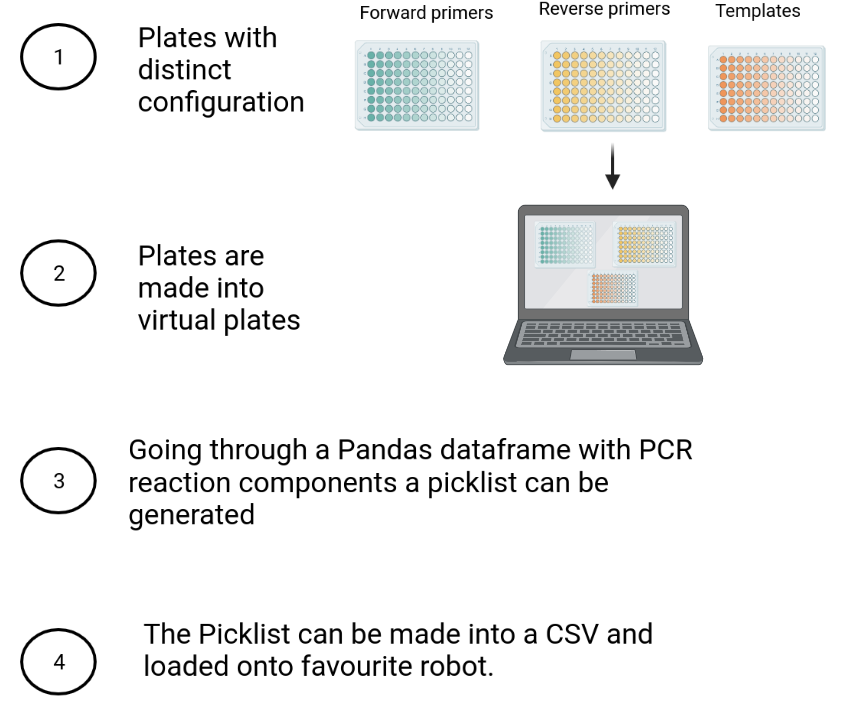

In [33]:
display.Image('ConStrain_on_google_colab/pictures/ROBOTassembly.png')

As an example we can make some virtual plates from the list of primers and templates

We can for example choose the promoter MSL1 and generate a picklist for that. We can slice it from the PCR dataframe like such: 

In [34]:
only_a_subset_templates = G8H_pcr_df.loc[G8H_pcr_df['Template']== 'pMLS1']
only_a_subset_templates

,PCR#,Template,forward_primer,reverse_primer,F_tm,R_tm
3,PCR4,pMLS1,F004,R122,56.11,56.18
24,PCR25,pMLS1,F060,R122,56.11,56.18
33,PCR34,pMLS1,F065,R122,56.11,56.18
42,PCR43,pMLS1,F070,R122,56.11,56.18


This step is just to make viirtual plate of primers that we generated earlier. These lists that are generated should be made from actual plates in the lab but this serves as an example how it could look like

In [35]:
fwd_primers = []
rev_primers = []
templates = []

for index,row in G8H_primer_df.iterrows(): 
    primers = row['ID']
    template = row['Anneals to']
    
    if primers.startswith('F'): 
        fwd_primers.append(primers)
    else:
        rev_primers.append(primers)
    
    if template not in templates: 
        templates.append(template)

These are all primers needed to construct the SLS library. We can take a subset of them (96) and make virtual plates and generate the instructions. 

In [36]:
f_primers = fwd_primers[:96]
r_primers = rev_primers[:96]
templates = templates[:96]


In [38]:
from constrain.lab.robot_assembly import RobotAssembly

In [39]:
Robot_intstructions_test = RobotAssembly( Pandas_dataframe_PCR = only_a_subset_templates, F_primers=f_primers, R_primers = r_primers, Templates= templates)

Now a good thing to do is look at the virtual plates that we have generated with the RobotAssembly object. It can be done in a few ways but here are 2: 

1. Each plate can be accessed an made into a dataframe
2. All the plates can be printed at once. 



In [40]:
# source_plateF_primers is a class instance and can be access like this: 
Robot_intstructions_test.source_plateF_primers.to_pandas_dataframe()

,name,content,row,column
A1,A1,"{'volume': 5.0, 'quantities': {'F001': 1}}",1,1
A2,A2,"{'volume': 5.0, 'quantities': {'F002': 1}}",1,2
A3,A3,"{'volume': 5.0, 'quantities': {'F003': 1}}",1,3
A4,A4,"{'volume': 5.0, 'quantities': {'F004': 1}}",1,4
A5,A5,"{'volume': 5.0, 'quantities': {'F005': 1}}",1,5
...,...,...,...,...
H8,H8,"{'volume': 5.0, 'quantities': {'F092': 1}}",8,8
H9,H9,"{'volume': 5.0, 'quantities': {'F093': 1}}",8,9
H10,H10,"{'volume': 5.0, 'quantities': {'F094': 1}}",8,10
H11,H11,"{'volume': 5.0, 'quantities': {'F095': 1}}",8,11


With the *print_well_df_to_string* method we can print all the wells in one go. 


Lets check out the picklist generated for the PCR reactions we made in FLOWBOT INSTRUCTIONS

The first number from the source and target columns indicate which plate the action is performed on, followed by which well. 

So this: 

source, target, volume
1:A4, 5:A1, 1 

means that plate 1, well A4 is transferd to target plate 5, A1 and the volume is 1. 

In [41]:
from constrain.lab.robot_assembly import LiquidHandler

In [42]:
print(Robot_intstructions_test.picklist.to_plain_string())

Transfer 1.00E+00L from 1 A4 into 5 A1
Transfer 1.00E+00L from 2 B7 into 5 A1
Transfer 1.00E+00L from 3 A4 into 5 A1
Transfer 1.00E+01L from 4 A1 into 5 A1
Transfer 7.00E+00L from 4 A2 into 5 A1
Transfer 1.00E+00L from 1 E12 into 5 A2
Transfer 1.00E+00L from 2 B7 into 5 A2
Transfer 1.00E+00L from 3 A4 into 5 A2
Transfer 1.00E+01L from 4 A1 into 5 A2
Transfer 7.00E+00L from 4 A2 into 5 A2
Transfer 1.00E+00L from 1 F5 into 5 A3
Transfer 1.00E+00L from 2 B7 into 5 A3
Transfer 1.00E+00L from 3 A4 into 5 A3
Transfer 1.00E+01L from 4 A1 into 5 A3
Transfer 7.00E+00L from 4 A2 into 5 A3
Transfer 1.00E+00L from 1 F10 into 5 A4
Transfer 1.00E+00L from 2 B7 into 5 A4
Transfer 1.00E+00L from 3 A4 into 5 A4
Transfer 1.00E+01L from 4 A1 into 5 A4
Transfer 7.00E+00L from 4 A2 into 5 A4


## Conclusion

1. A combinatorial library was made
2. Instructions for Flowbot One was automatically generated for the assembly of the combinatorial library. 